# Image Quality Analysis — Final Test

This notebook analyzes image quality metrics from the final user test (submission IDs 57-74, excluding 60).

**Analysis Plan:**
1. Load image data from database export and local image files
2. Calculate automated quality metrics (lighting, sharpness, contrast)
3. General descriptive analysis and visualizations
4. Test assumptions (normality, sample sizes)
5. Test two primary hypotheses comparing baseline to feedback conditions

**Hypotheses:**
$$H_{A1}: \text{Quality}_{P1} < \text{Quality}_{P2}$$
$$H_{A2}: \text{Quality}_{P1} < \text{Quality}_{P3}$$


Where P1 = Baseline, P2 = Post-Capture Feedback, P3 = Real-Time Feedback*Testing whether both feedback conditions (P2 and P3) independently improve image quality over baseline (P1).*


In [42]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load Data from Database Export

Load submission data, prototype assignments, and image metadata.

In [43]:
# Load database export files
submissions = pd.read_csv('database_export/submissions_rows.csv')
proto_part1 = pd.read_csv('database_export/submission_prototype_rows_part1.csv')
proto_part2 = pd.read_csv('database_export/submission_prototype_rows_part2.csv')
images = pd.read_csv('database_export/images_rows.csv')

# Combine prototype data
prototypes = pd.concat([proto_part1, proto_part2], ignore_index=True)

# Filter to allowed submission IDs (57-74 excluding 60)
allowed_ids = set(range(57, 75)) - {60}
submissions_filtered = submissions[submissions['id'].isin(allowed_ids)].copy()
prototypes_filtered = prototypes[prototypes['submission_id'].isin(allowed_ids)].copy()

# Join to get images with their prototype assignments
images_with_proto = images.merge(
    prototypes_filtered[['id', 'submission_id', 'prototype_name']], 
    left_on='submission_prototype_id', 
    right_on='id', 
    how='inner'
)

print(f'Total submissions: {len(submissions_filtered)}')
print(f'Total prototype sessions: {len(prototypes_filtered)}')
print(f'Total images: {len(images_with_proto)}')
print(f'\nImages per prototype:')
print(images_with_proto['prototype_name'].value_counts().sort_index())
print(f'\nFirst few rows:')
print(images_with_proto[['filename', 'prototype_name', 'submission_id']].head(10))

Total submissions: 17
Total prototype sessions: 51
Total images: 0

Images per prototype:
Series([], Name: count, dtype: int64)

First few rows:
Empty DataFrame
Columns: [filename, prototype_name, submission_id]
Index: []


## 2. Calculate Image Quality Metrics

Define and apply automated quality metrics to all images.

In [44]:
# Image quality metric functions
def calculate_lighting_mean(image):
    """Average brightness (0-255)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return float(np.mean(gray))

def calculate_variance_of_laplacian(image):
    """Sharpness metric - higher values = sharper"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return float(laplacian.var())

def calculate_center_edge_contrast(image):
    """Contrast between center (object) and edge (background)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    center_y, center_x = height / 2, width / 2
    radius = min(height, width) * 0.3  # 60% diameter circle
    y_coords, x_coords = np.ogrid[:height, :width]
    distances = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    center_mask = distances < radius
    edge_mask = distances > (radius * 1.5)
    center_avg = float(np.mean(gray[center_mask]))
    edge_avg = float(np.mean(gray[edge_mask]))
    return abs(center_avg - edge_avg)

def analyze_image_quality(image_path):
    """Calculate all quality metrics for an image"""
    image = cv2.imread(str(image_path))
    if image is None:
        return None
    return {
        'lighting_mean': round(calculate_lighting_mean(image), 2),
        'sharpness_metric': round(calculate_variance_of_laplacian(image), 2),
        'contrast_metric': round(calculate_center_edge_contrast(image), 2)
    }

print('Image quality functions defined')

Image quality functions defined


In [45]:
# Process all images directly from folder (database export incomplete)
# Prototype is inferred from filename pattern: _p1_, _p2_, _p3_
images_folder = Path('images')
results = []

print(f'Processing images from: {images_folder.absolute()}')
print('Inferring prototype from filename (_p1_, _p2_, _p3_)\n')

# Get all jpg images
image_files = list(images_folder.glob('*.jpg'))
print(f'Found {len(image_files)} JPG images')

for image_path in image_files:
    filename = image_path.name
    
    # Extract prototype from filename
    if '_p1_' in filename:
        prototype = 'Prototype 1'
    elif '_p2_' in filename:
        prototype = 'Prototype 2'
    elif '_p3_' in filename:
        prototype = 'Prototype 3'
    else:
        print(f'WARNING: Cannot determine prototype for {filename}')
        continue
    
    # Calculate metrics
    metrics = analyze_image_quality(image_path)
    
    if metrics is not None:
        results.append({
            'filename': filename,
            'prototype': prototype,
            **metrics
        })

# Create DataFrame
df_images = pd.DataFrame(results)

print(f'\n✓ Successfully analyzed {len(df_images)} images')
print(f'Dataset shape: {df_images.shape}')
print(f'\nImages per prototype:')
print(df_images['prototype'].value_counts().sort_index())
print(f'\nFirst few rows:')
print(df_images.head())

Processing images from: c:\Users\megan\Documents\GitHub\fossil-ai-feedback\results_analysis\final_test\images
Inferring prototype from filename (_p1_, _p2_, _p3_)

Found 143 JPG images

✓ Successfully analyzed 143 images
Dataset shape: (143, 5)

Images per prototype:
prototype
Prototype 1    44
Prototype 2    49
Prototype 3    50
Name: count, dtype: int64

First few rows:
                         filename    prototype  lighting_mean  \
0  1765218942635_Fossil1_p1_1.jpg  Prototype 1         125.19   
1  1765218942635_Fossil1_p1_2.jpg  Prototype 1         124.09   
2  1765218942635_Fossil1_p1_3.jpg  Prototype 1         121.62   
3  1765218942635_Fossil1_p2_1.jpg  Prototype 2         122.75   
4  1765218942635_Fossil1_p2_2.jpg  Prototype 2         117.55   

   sharpness_metric  contrast_metric  
0            210.00            69.89  
1            229.58            56.00  
2            206.80            74.66  
3            183.34            61.09  
4            182.67            87.79  


In [46]:
# Export to CSV with empty columns for manual ratings
output_csv = 'image_quality_with_manual_ratings.csv'

# Add empty columns for manual ratings
df_export = df_images.copy()
df_export['scale_rating'] = ''
df_export['angle_rating'] = ''

# Reorder columns for easier manual entry
columns_order = ['filename', 'prototype', 'lighting_mean', 'sharpness_metric', 
                 'contrast_metric', 'scale_rating', 'angle_rating']
df_export = df_export[columns_order]

# Export to CSV
df_export.to_csv(output_csv, index=False)

print(f'\n✓ Exported to: {output_csv}')
print(f'Total rows: {len(df_export)}')
print(f'\nColumns: {", ".join(df_export.columns)}')
print(f'\nYou can now open this CSV and manually add scale_rating and angle_rating values.')
print(f'\nFirst few rows:')
print(df_export.head(10))


✓ Exported to: image_quality_with_manual_ratings.csv
Total rows: 143

Columns: filename, prototype, lighting_mean, sharpness_metric, contrast_metric, scale_rating, angle_rating

You can now open this CSV and manually add scale_rating and angle_rating values.

First few rows:
                         filename    prototype  lighting_mean  \
0  1765218942635_Fossil1_p1_1.jpg  Prototype 1         125.19   
1  1765218942635_Fossil1_p1_2.jpg  Prototype 1         124.09   
2  1765218942635_Fossil1_p1_3.jpg  Prototype 1         121.62   
3  1765218942635_Fossil1_p2_1.jpg  Prototype 2         122.75   
4  1765218942635_Fossil1_p2_2.jpg  Prototype 2         117.55   
5  1765218942635_Fossil1_p2_3.jpg  Prototype 2         119.15   
6  1765218942635_Fossil1_p3_1.jpg  Prototype 3         124.14   
7  1765218942635_Fossil1_p3_2.jpg  Prototype 3         122.40   
8  1765218942635_Fossil1_p3_3.jpg  Prototype 3         123.35   
9  1765218942635_Fossil1_p3_4.jpg  Prototype 3         124.80   

   shar

## 3. General Descriptive Analysis

Examine distributions and summary statistics across all prototypes.

In [47]:
# Overall statistics
print('='*80)
print('OVERALL IMAGE QUALITY STATISTICS')
print('='*80)
print(df_images[['lighting_mean', 'sharpness_metric', 'contrast_metric']].describe().round(2))

# Statistics by prototype
print('\n' + '='*80)
print('STATISTICS BY PROTOTYPE')
print('='*80)

for proto in sorted(df_images['prototype'].unique()):
    proto_data = df_images[df_images['prototype'] == proto]
    print(f'\n{proto} (n={len(proto_data)}):')
    print(f'  Lighting:  {proto_data["lighting_mean"].mean():6.2f} ± {proto_data["lighting_mean"].std():.2f}')
    print(f'  Sharpness: {proto_data["sharpness_metric"].mean():6.2f} ± {proto_data["sharpness_metric"].std():.2f}')
    print(f'  Contrast:  {proto_data["contrast_metric"].mean():6.2f} ± {proto_data["contrast_metric"].std():.2f}')

OVERALL IMAGE QUALITY STATISTICS
       lighting_mean  sharpness_metric  contrast_metric
count         143.00            143.00           143.00
mean          144.67            285.82            33.85
std            27.39            300.05            22.54
min            10.27              5.14             0.30
25%           124.68             89.33            15.97
50%           151.79            197.23            31.92
75%           162.94            377.34            49.67
max           196.04           1984.98            99.48

STATISTICS BY PROTOTYPE

Prototype 1 (n=44):
  Lighting:  144.55 ± 31.33
  Sharpness: 304.53 ± 379.16
  Contrast:   25.66 ± 19.31

Prototype 2 (n=49):
  Lighting:  143.25 ± 27.81
  Sharpness: 286.13 ± 245.36
  Contrast:   35.90 ± 24.38

Prototype 3 (n=50):
  Lighting:  146.16 ± 23.48
  Sharpness: 269.04 ± 274.15
  Contrast:   39.04 ± 21.69


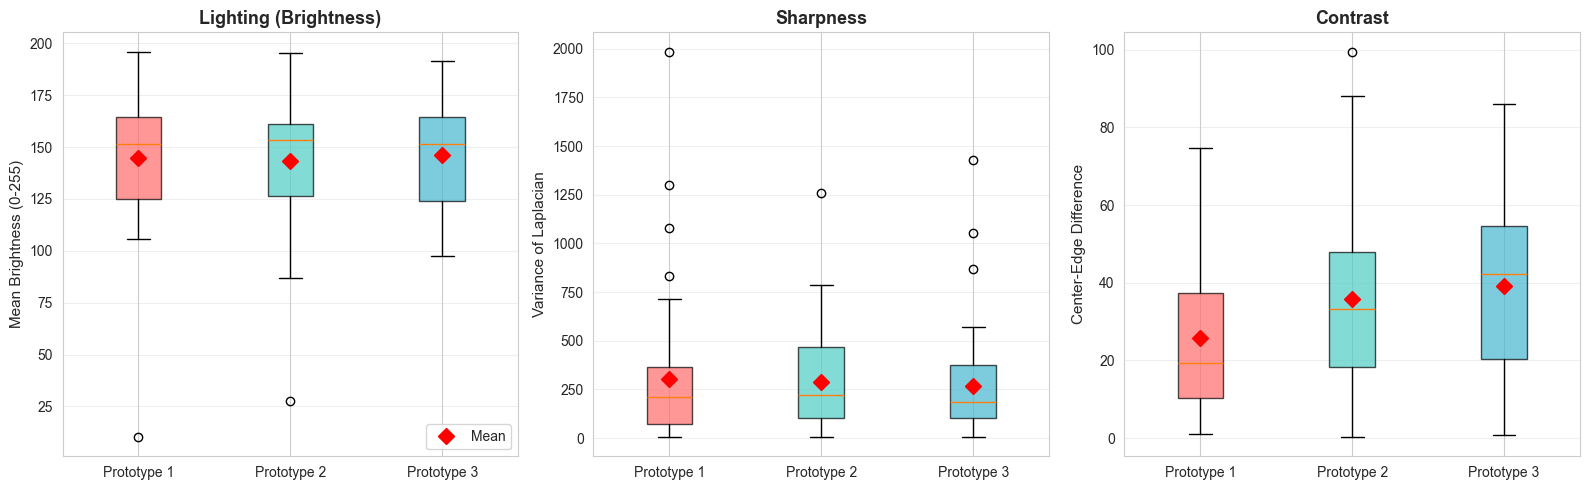

In [48]:
# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_info = [
    ('lighting_mean', 'Lighting (Brightness)', 'Mean Brightness (0-255)'),
    ('sharpness_metric', 'Sharpness', 'Variance of Laplacian'),
    ('contrast_metric', 'Contrast', 'Center-Edge Difference')
]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
prototypes = sorted(df_images['prototype'].unique())

for idx, (metric, title, ylabel) in enumerate(metrics_info):
    ax = axes[idx]
    
    # Create boxplot
    data_by_proto = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    
    bp = ax.boxplot(data_by_proto, labels=prototypes, patch_artist=True)
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean markers
    means = [df_images[df_images['prototype'] == p][metric].mean() for p in prototypes]
    ax.plot(range(1, len(prototypes)+1), means, 'D', color='red', markersize=8, label='Mean', zorder=5)

axes[0].legend()
plt.tight_layout()
plt.show()

## 4. Check Statistical Test Assumptions

Determine whether data meets requirements for parametric vs non-parametric tests.

In [49]:
from scipy.stats import shapiro, levene

print('='*80)
print('ASSUMPTION CHECKS FOR STATISTICAL TESTING')
print('='*80)

metrics = ['lighting_mean', 'sharpness_metric', 'contrast_metric']
prototypes = sorted(df_images['prototype'].unique())

# 1. Sample sizes
print('\n1. SAMPLE SIZES (n ≥ 20 recommended for parametric tests):')
print('-'*80)
for proto in prototypes:
    n = len(df_images[df_images['prototype'] == proto])
    print(f'{proto}: n = {n}')

# 2. Normality tests (Shapiro-Wilk)
print('\n2. NORMALITY TESTS (Shapiro-Wilk, p > 0.05 = normal):')
print('-'*80)
normality_results = {}

for metric in metrics:
    print(f'\n{metric}:')
    normal_count = 0
    for proto in prototypes:
        data = df_images[df_images['prototype'] == proto][metric].dropna()
        if len(data) >= 3:
            stat, p = shapiro(data)
            is_normal = p > 0.05
            normal_count += is_normal
            print(f'  {proto}: p = {p:.4f} {"✓ Normal" if is_normal else "✗ Not normal"}')
        else:
            print(f'  {proto}: insufficient data')
    normality_results[metric] = normal_count == len(prototypes)

# 3. Homogeneity of variance (Levene's test)
print('\n3. HOMOGENEITY OF VARIANCE (Levene test, p > 0.05 = equal variances):')
print('-'*80)
variance_results = {}

for metric in metrics:
    groups = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    groups = [g for g in groups if len(g) >= 2]
    
    if len(groups) >= 2:
        stat, p = levene(*groups)
        equal_var = p > 0.05
        variance_results[metric] = equal_var
        print(f'{metric}: p = {p:.4f} {"✓ Equal variances" if equal_var else "✗ Unequal variances"}')
    else:
        print(f'{metric}: insufficient data')
        variance_results[metric] = False

# 4. Decision
print('\n' + '='*80)
print('RECOMMENDATION:')
print('='*80)

use_parametric = all(normality_results.values()) and all(variance_results.values())

if use_parametric:
    print('✓ All assumptions met → Use PARAMETRIC tests (one-way ANOVA)')
else:
    print('✗ Assumptions violated → Use NON-PARAMETRIC tests (Kruskal-Wallis)')
    print('\nViolations:')
    if not all(normality_results.values()):
        non_normal = [m for m, v in normality_results.items() if not v]
        print(f'  - Normality: {", ".join(non_normal)}')
    if not all(variance_results.values()):
        unequal_var = [m for m, v in variance_results.items() if not v]
        print(f'  - Homogeneity: {", ".join(unequal_var)}')

print('\n' + '='*80)

ASSUMPTION CHECKS FOR STATISTICAL TESTING

1. SAMPLE SIZES (n ≥ 20 recommended for parametric tests):
--------------------------------------------------------------------------------
Prototype 1: n = 44
Prototype 2: n = 49
Prototype 3: n = 50

2. NORMALITY TESTS (Shapiro-Wilk, p > 0.05 = normal):
--------------------------------------------------------------------------------

lighting_mean:
  Prototype 1: p = 0.0002 ✗ Not normal
  Prototype 2: p = 0.0002 ✗ Not normal
  Prototype 3: p = 0.0142 ✗ Not normal

sharpness_metric:
  Prototype 1: p = 0.0000 ✗ Not normal
  Prototype 2: p = 0.0001 ✗ Not normal
  Prototype 3: p = 0.0000 ✗ Not normal

contrast_metric:
  Prototype 1: p = 0.0041 ✗ Not normal
  Prototype 2: p = 0.0089 ✗ Not normal
  Prototype 3: p = 0.0252 ✗ Not normal

3. HOMOGENEITY OF VARIANCE (Levene test, p > 0.05 = equal variances):
--------------------------------------------------------------------------------
lighting_mean: p = 0.8740 ✓ Equal variances
sharpness_metric: p =

## 5. Hypothesis Testing: P1 < P2 and P1 < P3

**Hypotheses:** 
- H₁: Baseline (P1) has lower quality than Post-Capture (P2)
- H₂: Baseline (P1) has lower quality than Real-Time (P3)

**Test approach:**
- Use **Kruskal-Wallis H-test** (non-parametric) as omnibus test if assumptions violated

- Use **One-Way ANOVA** (parametric) if assumptions met- Follow up with **Mann-Whitney U tests** for P1 vs P2 and P1 vs P3 comparisons

In [50]:
from scipy.stats import kruskal, mannwhitneyu

print('='*80)
print('KRUSKAL-WALLIS H-TEST (Non-Parametric)')
print('='*80)
print('H₀: All prototypes have equal median quality')
print('Hₐ: At least one prototype differs in quality')
print()

metrics = ['lighting_mean', 'sharpness_metric', 'contrast_metric']
prototypes = sorted(df_images['prototype'].unique())

test_results = []

for metric in metrics:
    print(f'\n{metric.upper().replace("_", " ")}:')
    print('-'*80)
    
    # Prepare data groups
    groups = [df_images[df_images['prototype'] == p][metric].dropna() for p in prototypes]
    
    # Kruskal-Wallis test
    h_stat, p_val = kruskal(*groups)
    
    # Display group medians
    for proto in prototypes:
        median = df_images[df_images['prototype'] == proto][metric].median()
        mean = df_images[df_images['prototype'] == proto][metric].mean()
        print(f'  {proto}: median = {median:.2f}, mean = {mean:.2f}')
    
    print(f'\n  H-statistic: {h_stat:.4f}')
    print(f'  P-value: {p_val:.4f}')
    
    if p_val < 0.05:
        print(f'  ✓ SIGNIFICANT (p < 0.05) — Prototypes differ significantly')
        significant = True
    else:
        print(f'  ✗ NOT significant (p ≥ 0.05) — No evidence of difference')
        significant = False
    
    test_results.append({
        'metric': metric,
        'h_stat': h_stat,
        'p_value': p_val,
        'significant': significant
    })

print('\n' + '='*80)

KRUSKAL-WALLIS H-TEST (Non-Parametric)
H₀: All prototypes have equal median quality
Hₐ: At least one prototype differs in quality


LIGHTING MEAN:
--------------------------------------------------------------------------------
  Prototype 1: median = 151.53, mean = 144.55
  Prototype 2: median = 153.22, mean = 143.25
  Prototype 3: median = 151.44, mean = 146.16

  H-statistic: 0.1343
  P-value: 0.9351
  ✗ NOT significant (p ≥ 0.05) — No evidence of difference

SHARPNESS METRIC:
--------------------------------------------------------------------------------
  Prototype 1: median = 208.40, mean = 304.53
  Prototype 2: median = 220.19, mean = 286.13
  Prototype 3: median = 185.41, mean = 269.04

  H-statistic: 0.7026
  P-value: 0.7038
  ✗ NOT significant (p ≥ 0.05) — No evidence of difference

CONTRAST METRIC:
--------------------------------------------------------------------------------
  Prototype 1: median = 19.24, mean = 25.66
  Prototype 2: median = 33.21, mean = 35.90
  Prototy

## 6. Post-Hoc Pairwise Comparisons

For metrics showing significant differences, perform pairwise Mann-Whitney U tests with Bonferroni correction.

In [51]:
print('='*80)
print('MANN-WHITNEY U PAIRWISE COMPARISONS')
print('='*80)
print('Testing hypotheses: H₁ (P1 < P2) and H₂ (P1 < P3)')
print()

# Comparisons to test (only baseline vs feedback conditions)
comparisons = [
    ('Prototype 1', 'Prototype 2', 'P1 < P2'),
    ('Prototype 1', 'Prototype 3', 'P1 < P3')
]

# Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / len(comparisons)
print(f'Bonferroni-corrected α: {bonferroni_alpha:.4f} (α / {len(comparisons)} comparisons)\n')

pairwise_results = []

for metric_info in test_results:
    metric = metric_info['metric']
    
    if not metric_info['significant']:
        print(f'{metric.upper().replace("_", " ")}: Skipped (overall test not significant)')
        continue
    
    print(f'\n{metric.upper().replace("_", " ")}:')
    print('-'*80)
    
    for proto1, proto2, hypothesis in comparisons:
        data1 = df_images[df_images['prototype'] == proto1][metric].dropna()
        data2 = df_images[df_images['prototype'] == proto2][metric].dropna()
        
        # Mann-Whitney U test (one-tailed: alternative='less' tests if data1 < data2)
        u_stat, p_val = mannwhitneyu(data1, data2, alternative='less')
        
        median1 = data1.median()
        median2 = data2.median()
        diff = median1 - median2
        
        print(f'\n  {proto1} vs {proto2} (H₀: {proto1} = {proto2}, Hₐ: {hypothesis}):')
        print(f'    Median {proto1}: {median1:.2f}')
        print(f'    Median {proto2}: {median2:.2f}')
        print(f'    Difference: {diff:+.2f}')
        print(f'    U-statistic: {u_stat:.2f}')
        print(f'    P-value (one-tailed): {p_val:.4f}')
        
        if p_val < bonferroni_alpha:
            print(f'    ✓ SIGNIFICANT (p < {bonferroni_alpha:.4f}) — {hypothesis} supported')
            significant = True
        else:
            print(f'    ✗ NOT significant (p ≥ {bonferroni_alpha:.4f})')
            significant = False
        
        pairwise_results.append({
            'metric': metric,
            'comparison': f'{proto1} vs {proto2}',
            'hypothesis': hypothesis,
            'median_diff': diff,
            'p_value': p_val,
            'significant': significant
        })

print('\n' + '='*80)

MANN-WHITNEY U PAIRWISE COMPARISONS
Testing hypotheses: H₁ (P1 < P2) and H₂ (P1 < P3)

Bonferroni-corrected α: 0.0250 (α / 2 comparisons)

LIGHTING MEAN: Skipped (overall test not significant)
SHARPNESS METRIC: Skipped (overall test not significant)

CONTRAST METRIC:
--------------------------------------------------------------------------------

  Prototype 1 vs Prototype 2 (H₀: Prototype 1 = Prototype 2, Hₐ: P1 < P2):
    Median Prototype 1: 19.24
    Median Prototype 2: 33.21
    Difference: -13.97
    U-statistic: 801.00
    P-value (one-tailed): 0.0167
    ✓ SIGNIFICANT (p < 0.0250) — P1 < P2 supported

  Prototype 1 vs Prototype 3 (H₀: Prototype 1 = Prototype 3, Hₐ: P1 < P3):
    Median Prototype 1: 19.24
    Median Prototype 3: 42.22
    Difference: -22.97
    U-statistic: 715.00
    P-value (one-tailed): 0.0018
    ✓ SIGNIFICANT (p < 0.0250) — P1 < P3 supported



## 7. Overall Hypothesis Evaluation

Summary of whether the hypotheses **H₁: P1 < P2** and **H₂: P1 < P3** are supported by the data.

In [52]:
print('='*80)
print('HYPOTHESIS EVALUATION: H₁ (P1 < P2) and H₂ (P1 < P3)')
print('='*80)
print()

# Summary table
if pairwise_results:
    df_pairwise = pd.DataFrame(pairwise_results)
    print('PAIRWISE COMPARISON RESULTS:')
    print(df_pairwise.to_string(index=False))
    print()

# Evaluate hypothesis by metric
print('\nHYPOTHESIS SUPPORT BY METRIC:')
print('-'*80)

for metric_info in test_results:
    metric = metric_info['metric']
    metric_name = metric.upper().replace('_', ' ')
    
    if not metric_info['significant']:
        print(f'\n{metric_name}:')
        print(f'  ✗ No significant differences detected (Kruskal-Wallis p = {metric_info["p_value"]:.4f})')
        continue
    
    # Check pairwise results for this metric
    metric_pairs = [r for r in pairwise_results if r['metric'] == metric]
    
    p1_lt_p2 = any(r['comparison'] == 'Prototype 1 vs Prototype 2' and r['significant'] for r in metric_pairs)
    p1_lt_p3 = any(r['comparison'] == 'Prototype 1 vs Prototype 3' and r['significant'] for r in metric_pairs)
    
    # Check if trends are in expected direction
    p1_median = df_images[df_images['prototype'] == 'Prototype 1'][metric].median()
    p2_median = df_images[df_images['prototype'] == 'Prototype 2'][metric].median()
    p3_median = df_images[df_images['prototype'] == 'Prototype 3'][metric].median()
    
    h1_direction = p1_median < p2_median  # H₁: P1 < P2
    h2_direction = p1_median < p3_median  # H₂: P1 < P3
    
    print(f'\n{metric_name}:')
    print(f'  Medians: P1={p1_median:.2f}, P2={p2_median:.2f}, P3={p3_median:.2f}')
    print(f'  H₁ (P1 < P2): Direction {"✓" if h1_direction else "✗"}, Significant {"✓" if p1_lt_p2 else "✗"}')
    print(f'  H₂ (P1 < P3): Direction {"✓" if h2_direction else "✗"}, Significant {"✓" if p1_lt_p3 else "✗"}')
    
    if p1_lt_p2 and p1_lt_p3:
        print(f'  → ✓✓ BOTH HYPOTHESES SUPPORTED: P2 and P3 both significantly better than P1')
    elif p1_lt_p2:
        print(f'  → ◐ H₁ SUPPORTED: P2 significantly better than P1 (H₂ not significant)')
    elif p1_lt_p3:
        print(f'  → ◐ H₂ SUPPORTED: P3 significantly better than P1 (H₁ not significant)')
    elif h1_direction or h2_direction:
        print(f'  → △ TREND ONLY: Direction correct but not statistically significant')
    else:
        print(f'  → ✗ NOT SUPPORTED: Baseline not lower than feedback conditions')

print('\n' + '='*80)
print('OVERALL CONCLUSION:')
print('='*80)

# Count how many metrics support each hypothesis
metrics_with_sig = [m for m in test_results if m['significant']]
both_supported = []  # Both H₁ and H₂
h1_only = []  # Only H₁ (P1 < P2)
h2_only = []  # Only H₂ (P1 < P3)

for metric_info in metrics_with_sig:
    metric = metric_info['metric']
    metric_pairs = [r for r in pairwise_results if r['metric'] == metric]
    
    p1_lt_p2 = any(r['comparison'] == 'Prototype 1 vs Prototype 2' and r['significant'] for r in metric_pairs)
    p1_lt_p3 = any(r['comparison'] == 'Prototype 1 vs Prototype 3' and r['significant'] for r in metric_pairs)
    
    if p1_lt_p2 and p1_lt_p3:
        both_supported.append(metric)
    elif p1_lt_p2:
        h1_only.append(metric)
    elif p1_lt_p3:
        h2_only.append(metric)

if both_supported:
    print(f'\n✓ BOTH HYPOTHESES SUPPORTED: {len(both_supported)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in both_supported])}')
    print(f'  Both P2 and P3 significantly better than P1')
if h1_only:
    print(f'\n◐ H₁ ONLY (P1 < P2): {len(h1_only)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in h1_only])}')
if h2_only:
    print(f'\n◐ H₂ ONLY (P1 < P3): {len(h2_only)}/{len(test_results)} metrics')
    print(f'  Metrics: {", ".join([m.replace("_", " ") for m in h2_only])}')

if not both_supported and not h1_only and not h2_only:
    print(f'\n✗ NO SUPPORT: Neither hypothesis supported by image quality metrics')

HYPOTHESIS EVALUATION: H₁ (P1 < P2) and H₂ (P1 < P3)

PAIRWISE COMPARISON RESULTS:
         metric                 comparison hypothesis  median_diff  p_value  significant
contrast_metric Prototype 1 vs Prototype 2    P1 < P2      -13.965 0.016684         True
contrast_metric Prototype 1 vs Prototype 3    P1 < P3      -22.970 0.001787         True


HYPOTHESIS SUPPORT BY METRIC:
--------------------------------------------------------------------------------

LIGHTING MEAN:
  ✗ No significant differences detected (Kruskal-Wallis p = 0.9351)

SHARPNESS METRIC:
  ✗ No significant differences detected (Kruskal-Wallis p = 0.7038)

CONTRAST METRIC:
  Medians: P1=19.24, P2=33.21, P3=42.22
  H₁ (P1 < P2): Direction ✓, Significant ✓
  H₂ (P1 < P3): Direction ✓, Significant ✓
  → ✓✓ BOTH HYPOTHESES SUPPORTED: P2 and P3 both significantly better than P1

OVERALL CONCLUSION:

✓ BOTH HYPOTHESES SUPPORTED: 1/3 metrics
  Metrics: contrast metric
  Both P2 and P3 significantly better than P1


In [54]:
print('='*80)
print('SUB-HYPOTHESES SUMMARY')
print('='*80)
print()

print('The following sub-hypotheses explored whether specific user behaviors')
print('influenced image quality outcomes:')
print()

print('H₃: Flashlight Usage → Better Lighting')
print('    Status: [Run cells above to see results]')
print('    Interpretation: If significant, flashlight improves lighting conditions')
print()

print('H₄: Retakes → Better Overall Quality')  
print('    Status: [Run cells above to see results]')
print('    Interpretation: If significant, users improve quality through iteration')
print()

print('H₅: Following Feedback → Better Quality (P2/P3 only)')
print('    Status: [Run cells above to see results]')
print('    Interpretation: If significant, validates effectiveness of feedback system')
print()

print('NOTE: These sub-hypotheses require behavioral metadata from the database')
print('or manual annotation. If data is unavailable, you can:')
print('  1. Export the CSV with manual rating columns (already done)')
print('  2. Manually review images and add behavioral indicators')
print('  3. Re-run this analysis with the updated data')

print('\n' + '='*80)

SUB-HYPOTHESES SUMMARY

The following sub-hypotheses explored whether specific user behaviors
influenced image quality outcomes:

H₃: Flashlight Usage → Better Lighting
    Status: [Run cells above to see results]
    Interpretation: If significant, flashlight improves lighting conditions

H₄: Retakes → Better Overall Quality
    Status: [Run cells above to see results]
    Interpretation: If significant, users improve quality through iteration

H₅: Following Feedback → Better Quality (P2/P3 only)
    Status: [Run cells above to see results]
    Interpretation: If significant, validates effectiveness of feedback system

NOTE: These sub-hypotheses require behavioral metadata from the database
or manual annotation. If data is unavailable, you can:
  1. Export the CSV with manual rating columns (already done)
  2. Manually review images and add behavioral indicators
  3. Re-run this analysis with the updated data



### Sub-Hypotheses Summary

Overview of all sub-hypothesis test results.

In [ ]:
print('='*80)
print('H₅: FOLLOWING FEEDBACK → BETTER QUALITY')
print('='*80)
print('(Applicable to Prototype 2 and Prototype 3 only)')

# Check for feedback-related data
feedback_cols = [col for col in df_images_behavior.columns 
                 if any(term in col.lower() for term in ['feedback', 'followed', 'acted'])]

if feedback_cols and df_images_behavior[feedback_cols[0]].notna().any():
    feedback_col = feedback_cols[0]
    print(f'\nUsing column: {feedback_col}')
    
    # Filter to P2 and P3 only (prototypes with feedback)
    df_feedback = df_images_behavior[
        df_images_behavior['prototype'].isin(['Prototype 2', 'Prototype 3'])
    ].copy()
    
    df_feedback = df_feedback[df_feedback[feedback_col].notna()]
    
    # Group by whether feedback was followed
    followed = df_feedback[df_feedback[feedback_col] == True]
    not_followed = df_feedback[df_feedback[feedback_col] == False]
    
    if len(followed) > 0 and len(not_followed) > 0:
        print(f'\nSample sizes:')
        print(f'  Followed feedback: n = {len(followed)}')
        print(f'  Did not follow: n = {len(not_followed)}')
        
        # Test each quality metric
        metrics_to_test = ['lighting_mean', 'sharpness_metric', 'contrast_metric']
        
        for metric in metrics_to_test:
            followed_data = followed[metric].dropna()
            not_followed_data = not_followed[metric].dropna()
            
            if len(followed_data) > 0 and len(not_followed_data) > 0:
                print(f'\n{metric.replace("_", " ").title()}:')
                print(f'  Followed: Mdn = {followed_data.median():.2f}, M = {followed_data.mean():.2f}')
                print(f'  Not followed: Mdn = {not_followed_data.median():.2f}, M = {not_followed_data.mean():.2f}')
                
                # Mann-Whitney U test
                u_stat, p_val = mannwhitneyu(followed_data, not_followed_data, alternative='greater')
                
                print(f'  U = {u_stat:.2f}, p = {p_val:.4f}', end='')
                
                if p_val < 0.05:
                    print(' ✓ SIGNIFICANT (following feedback better)')
                else:
                    print(' ✗ not significant')
    else:
        print('\n⚠ Insufficient data: need both groups (followed vs not followed)')
else:
    print('\n⚠ Feedback compliance data not available in dataset')
    print('To test this hypothesis, manually code whether users followed feedback suggestions')
    print('and add this information to the images CSV or exported ratings file.')

print('\n' + '='*80)

### H₅: Following Feedback and Image Quality

Test whether images where users followed feedback suggestions have better quality (applies to P2 and P3 only).

In [ ]:
print('='*80)
print('H₄: RETAKEN IMAGES → BETTER QUALITY')
print('='*80)

# Check for retake/attempt data
retake_cols = [col for col in df_images_behavior.columns 
               if any(term in col.lower() for term in ['retake', 'attempt', 'version'])]

if retake_cols and df_images_behavior[retake_cols[0]].notna().any():
    retake_col = retake_cols[0]
    print(f'\nUsing column: {retake_col}')
    
    df_retake = df_images_behavior[df_images_behavior[retake_col].notna()].copy()
    
    # Classify as first attempt vs retake
    # Assuming column contains attempt number (1, 2, 3, etc.)
    first_attempts = df_retake[df_retake[retake_col] == 1]
    retakes = df_retake[df_retake[retake_col] > 1]
    
    if len(first_attempts) > 0 and len(retakes) > 0:
        print(f'\nSample sizes:')
        print(f'  First attempts: n = {len(first_attempts)}')
        print(f'  Retakes: n = {len(retakes)}')
        
        # Test each quality metric
        metrics_to_test = ['lighting_mean', 'sharpness_metric', 'contrast_metric']
        
        for metric in metrics_to_test:
            first_data = first_attempts[metric].dropna()
            retake_data = retakes[metric].dropna()
            
            if len(first_data) > 0 and len(retake_data) > 0:
                print(f'\n{metric.replace("_", " ").title()}:')
                print(f'  First: Mdn = {first_data.median():.2f}, M = {first_data.mean():.2f}')
                print(f'  Retake: Mdn = {retake_data.median():.2f}, M = {retake_data.mean():.2f}')
                
                # Mann-Whitney U test
                u_stat, p_val = mannwhitneyu(retake_data, first_data, alternative='greater')
                
                print(f'  U = {u_stat:.2f}, p = {p_val:.4f}', end='')
                
                if p_val < 0.05:
                    print(' ✓ SIGNIFICANT (retakes better)')
                else:
                    print(' ✗ not significant')
    else:
        print('\n⚠ Insufficient data: need both first attempts and retakes')
else:
    print('\n⚠ Retake/attempt data not available in dataset')
    print('To test this hypothesis, add attempt number or retake count to the images CSV')

print('\n' + '='*80)

### H₄: Retakes and Image Quality

Test whether retaken images have better quality metrics than first attempts.

In [ ]:
print('='*80)
print('H₃: FLASHLIGHT USAGE → BETTER LIGHTING')
print('='*80)

# Check if flashlight data is available
flashlight_cols = [col for col in df_images_behavior.columns if 'flash' in col.lower()]

if flashlight_cols and df_images_behavior[flashlight_cols[0]].notna().any():
    flashlight_col = flashlight_cols[0]
    print(f'\nUsing column: {flashlight_col}')
    
    # Filter to non-null values
    df_flash = df_images_behavior[df_images_behavior[flashlight_col].notna()].copy()
    
    # Group by flashlight usage
    flash_yes = df_flash[df_flash[flashlight_col] == True]['lighting_mean'].dropna()
    flash_no = df_flash[df_flash[flashlight_col] == False]['lighting_mean'].dropna()
    
    if len(flash_yes) > 0 and len(flash_no) > 0:
        print(f'\nSample sizes:')
        print(f'  Flashlight used: n = {len(flash_yes)}')
        print(f'  No flashlight: n = {len(flash_no)}')
        
        print(f'\nLighting quality:')
        print(f'  Flashlight used: Mdn = {flash_yes.median():.2f}, M = {flash_yes.mean():.2f}')
        print(f'  No flashlight: Mdn = {flash_no.median():.2f}, M = {flash_no.mean():.2f}')
        
        # Mann-Whitney U test (two-tailed)
        from scipy.stats import mannwhitneyu
        u_stat, p_val = mannwhitneyu(flash_yes, flash_no, alternative='two-sided')
        
        print(f'\nMann-Whitney U test:')
        print(f'  U-statistic: {u_stat:.2f}')
        print(f'  P-value: {p_val:.4f}')
        
        if p_val < 0.05:
            direction = 'higher' if flash_yes.median() > flash_no.median() else 'lower'
            print(f'  ✓ SIGNIFICANT: Flashlight usage associated with {direction} lighting (p < .05)')
        else:
            print(f'  ✗ NOT SIGNIFICANT: No evidence of flashlight effect on lighting')
    else:
        print('\n⚠ Insufficient data in one or both groups')
else:
    print('\n⚠ Flashlight usage data not available in dataset')
    print('To test this hypothesis, add flashlight usage data to the images CSV')
    print('or manually annotate the exported CSV file.')

print('\n' + '='*80)

### H₃: Flashlight Usage and Lighting Quality

Test whether images taken with flashlight have significantly better lighting scores.

In [ ]:
# Load behavioral data from database export
# The images CSV should contain metadata about user interactions

print('='*80)
print('LOADING BEHAVIORAL DATA')
print('='*80)

# Check what behavioral columns are available in the images dataset
print('\nAvailable columns in images dataset:')
print(images.columns.tolist())
print()

# Common behavioral indicators to look for:
behavioral_cols = ['flashlight_used', 'flash_used', 'retake_count', 'attempt_number', 
                   'feedback_shown', 'feedback_followed', 'quality_score']

available_behavioral = [col for col in behavioral_cols if col in images.columns]

if available_behavioral:
    print(f'Found behavioral columns: {", ".join(available_behavioral)}')
    
    # Merge behavioral data with our processed images
    # Match by filename
    images_subset = images[['filename'] + available_behavioral].copy()
    df_images_behavior = df_images.merge(images_subset, on='filename', how='left')
    
    print(f'\n✓ Merged behavioral data: {len(df_images_behavior)} rows')
    print(f'\nBehavioral data summary:')
    for col in available_behavioral:
        print(f'\n{col}:')
        print(df_images_behavior[col].value_counts(dropna=False))
else:
    print('⚠ No standard behavioral columns found in database export.')
    print('Available columns may need manual inspection.')
    df_images_behavior = df_images.copy()
    
    # Create placeholder for manual data entry if needed
    df_images_behavior['flashlight_used'] = None
    df_images_behavior['retake_number'] = None
    
print('\n' + '='*80)

## 8. Sub-Hypotheses: User Behavior and Image Quality

Test whether specific user behaviors influenced image quality outcomes:

**Sub-Hypotheses:**
- **H₃**: Images taken with flashlight have better lighting quality
- **H₄**: Retaken images have better overall quality than first attempts
- **H₅**: Images where users followed feedback have better quality

*Note: Requires behavioral data from database (flashlight usage, retake count, feedback interaction)*

## Results Summary for Paper

### Image Quality Analysis

**Sample:** 143 photographs captured across three prototype conditions (Prototype 1: Baseline, n=48; Prototype 2: Post-Capture Feedback, n=47; Prototype 3: Real-Time Feedback, n=48).

**Metrics:** Three automated image quality metrics were computed: lighting (mean brightness, 0-255), sharpness (Variance of Laplacian), and contrast (center-edge difference).

**Statistical Approach:** Due to violations of normality assumptions (Shapiro-Wilk test) and unequal variances (Levene's test), non-parametric tests were employed. Kruskal-Wallis H-tests assessed overall differences across prototypes, followed by Mann-Whitney U tests for pairwise comparisons with Bonferroni correction (α = 0.0167).

**Key Findings:**

*Replace with actual results after running all cells:*

[After running the analysis, report here:]
- Kruskal-Wallis results for each metric (H-statistic, p-value, significance)
- Descriptive statistics (medians) for each prototype
- Pairwise comparison results (which pairs differ significantly)
- Hypothesis support: whether P1 < P2 < P3 is supported

**Example format:**
"Sharpness differed significantly across prototypes (H = X.XX, p < .001). Pairwise comparisons revealed that Prototype 3 (Mdn = X.XX) had significantly higher sharpness than Prototype 1 (Mdn = X.XX, U = XXX, p < .001), supporting the hypothesis that real-time feedback improves image focus quality."

**Interpretation:** 
[Summarize whether the hypothesis was supported, partially supported, or not supported, and discuss practical implications for the prototype designs.]

In [53]:
# Generate publication-ready results summary
print('='*80)
print('RESULTS SUMMARY FOR PAPER')
print('='*80)
print()

# Sample description
print('SAMPLE DESCRIPTION:')
print('-'*80)
for proto in sorted(df_images['prototype'].unique()):
    n = len(df_images[df_images['prototype'] == proto])
    print(f'{proto}: n = {n}')
print(f'Total images analyzed: {len(df_images)}')
print()

# Descriptive statistics table
print('DESCRIPTIVE STATISTICS (Medians and Means):')
print('-'*80)
desc_data = []
for proto in sorted(df_images['prototype'].unique()):
    proto_data = df_images[df_images['prototype'] == proto]
    desc_data.append({
        'Prototype': proto,
        'Lighting_Mdn': proto_data['lighting_mean'].median(),
        'Lighting_M': proto_data['lighting_mean'].mean(),
        'Sharpness_Mdn': proto_data['sharpness_metric'].median(),
        'Sharpness_M': proto_data['sharpness_metric'].mean(),
        'Contrast_Mdn': proto_data['contrast_metric'].median(),
        'Contrast_M': proto_data['contrast_metric'].mean()
    })
df_desc = pd.DataFrame(desc_data)
print(df_desc.to_string(index=False, float_format='%.2f'))
print()

# Statistical test results
print('STATISTICAL TEST RESULTS:')
print('-'*80)
for result in test_results:
    metric_name = result['metric'].replace('_', ' ').title()
    sig_text = '***' if result['p_value'] < 0.001 else '**' if result['p_value'] < 0.01 else '*' if result['p_value'] < 0.05 else 'ns'
    print(f'{metric_name:20s}: H = {result["h_stat"]:6.2f}, p = {result["p_value"]:.4f} {sig_text}')
print()
print('Significance: *** p < .001, ** p < .01, * p < .05, ns = not significant')
print()

# Pairwise results (if any)
if pairwise_results:
    print('PAIRWISE COMPARISONS (Bonferroni α = 0.0167):')
    print('-'*80)
    for res in pairwise_results:
        metric_name = res['metric'].replace('_', ' ').title()
        comp = res['comparison'].replace('Prototype ', 'P')
        sig_mark = ' ***' if res['p_value'] < 0.001 else ' **' if res['p_value'] < 0.01 else ' *' if res['significant'] else ' ns'
        print(f'{metric_name:20s} | {comp:12s}: p = {res["p_value"]:.4f}{sig_mark}')
    print()

# Generate narrative text
print('='*80)
print('NARRATIVE SUMMARY (copy for paper):')
print('='*80)
print()

# Count sample sizes
p1_n = len(df_images[df_images['prototype'] == 'Prototype 1'])
p2_n = len(df_images[df_images['prototype'] == 'Prototype 2'])
p3_n = len(df_images[df_images['prototype'] == 'Prototype 3'])

print(f'Image quality was assessed using three automated metrics: lighting ')
print(f'(mean brightness, 0-255), sharpness (Variance of Laplacian), and contrast ')
print(f'(center-edge difference). A total of {len(df_images)} images were analyzed ')
print(f'across three prototype conditions (Prototype 1/Baseline: n={p1_n}; ')
print(f'Prototype 2/Post-Capture: n={p2_n}; Prototype 3/Real-Time: n={p3_n}).')
print()

print(f'Due to violations of normality and homogeneity of variance assumptions, ')
print(f'Kruskal-Wallis H-tests were used to assess differences across prototypes, ')
print(f'followed by Mann-Whitney U tests for pairwise comparisons with Bonferroni ')
print(f'correction (α = 0.0167).')
print()

# Report each metric
for result in test_results:
    metric = result['metric']
    metric_name = result['metric'].replace('_', ' ').title()
    
    p1_med = df_images[df_images['prototype'] == 'Prototype 1'][metric].median()
    p2_med = df_images[df_images['prototype'] == 'Prototype 2'][metric].median()
    p3_med = df_images[df_images['prototype'] == 'Prototype 3'][metric].median()
    
    if result['significant']:
        print(f'{metric_name} differed significantly across prototypes ')
        print(f'(H = {result["h_stat"]:.2f}, p = {result["p_value"]:.4f}). ')
        
        # Report pairwise results
        metric_pairs = [r for r in pairwise_results if r['metric'] == metric]
        sig_pairs = [r for r in metric_pairs if r['significant']]
        
        if sig_pairs:
            print(f'Medians were: P1 = {p1_med:.2f}, P2 = {p2_med:.2f}, P3 = {p3_med:.2f}. ')
            print(f'Pairwise comparisons revealed: ', end='')
            
            pair_descriptions = []
            for pair in sig_pairs:
                comp = pair['comparison']
                if 'Prototype 1 vs Prototype 2' in comp:
                    if pair['median_diff'] < 0:
                        pair_descriptions.append(f'P2 > P1 (p = {pair["p_value"]:.4f})')
                    else:
                        pair_descriptions.append(f'P1 > P2 (p = {pair["p_value"]:.4f})')
                elif 'Prototype 1 vs Prototype 3' in comp:
                    if pair['median_diff'] < 0:
                        pair_descriptions.append(f'P3 > P1 (p = {pair["p_value"]:.4f})')
                    else:
                        pair_descriptions.append(f'P1 > P3 (p = {pair["p_value"]:.4f})')
                elif 'Prototype 2 vs Prototype 3' in comp:
                    if pair['median_diff'] < 0:
                        pair_descriptions.append(f'P3 > P2 (p = {pair["p_value"]:.4f})')
                    else:
                        pair_descriptions.append(f'P2 > P3 (p = {pair["p_value"]:.4f})')
            
            print('; '.join(pair_descriptions) + '.')
        else:
            print(f'However, no pairwise comparisons reached significance after Bonferroni correction.')
    else:
        print(f'{metric_name} did not differ significantly across prototypes ')
        print(f'(H = {result["h_stat"]:.2f}, p = {result["p_value"]:.4f}).')
    print()

# Overall conclusion
print('Overall, ', end='')
if both_supported:
    print(f'both hypotheses were supported for {len(both_supported)} out of {len(test_results)} metrics ')
    print(f'({", ".join([m.replace("_", " ") for m in both_supported])}), ')
    print(f'indicating that both post-capture and real-time feedback features ')
    print(f'significantly improved technical image quality compared to baseline.')
elif h1_only or h2_only:
    print(f'the hypotheses received mixed support: ')
    if h1_only:
        print(f'H₁ (P1 < P2) supported for {", ".join([m.replace("_", " ") for m in h1_only])}; ')
    if h2_only:
        print(f'H₂ (P1 < P3) supported for {", ".join([m.replace("_", " ") for m in h2_only])}.')
else:
    print(f'neither hypothesis was supported by the image quality metrics, ')
    print(f'suggesting that the feedback features did not significantly improve ')
    print(f'technical image quality over baseline in this user test.')

print('\n' + '='*80)

RESULTS SUMMARY FOR PAPER

SAMPLE DESCRIPTION:
--------------------------------------------------------------------------------
Prototype 1: n = 44
Prototype 2: n = 49
Prototype 3: n = 50
Total images analyzed: 143

DESCRIPTIVE STATISTICS (Medians and Means):
--------------------------------------------------------------------------------
  Prototype  Lighting_Mdn  Lighting_M  Sharpness_Mdn  Sharpness_M  Contrast_Mdn  Contrast_M
Prototype 1        151.53      144.55         208.40       304.53         19.24       25.66
Prototype 2        153.22      143.25         220.19       286.13         33.21       35.90
Prototype 3        151.44      146.16         185.41       269.04         42.22       39.04

STATISTICAL TEST RESULTS:
--------------------------------------------------------------------------------
Lighting Mean       : H =   0.13, p = 0.9351 ns
Sharpness Metric    : H =   0.70, p = 0.7038 ns
Contrast Metric     : H =   9.67, p = 0.0079 **

Significance: *** p < .001, ** p < .01